MuskRCNN基础训练教程  
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#finetuning-from-a-pretrained-model  
# 头文件导入

In [2]:
import os
import sys
import torch
import torchvision
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 数据集建立 

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# 载入预训练模型

In [3]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# 修饰模型更改骨干网络

In [4]:
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = torchvision.models.detection.FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

# 模型建立

In [5]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# 转换函数

In [6]:
import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# 前向函数建立

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('../datasets/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=0,
 collate_fn=collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
print(predictions)

C:\Users\11426\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward>)}]


In [9]:
from engine import train_one_epoch, evaluate
import utils



# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('../datasets/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('../datasets/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/120]  eta: 0:05:54  lr: 0.000047  loss: 8.0519 (8.0519)  loss_classifier: 0.6849 (0.6849)  loss_box_reg: 0.5395 (0.5395)  loss_mask: 6.7719 (6.7719)  loss_objectness: 0.0520 (0.0520)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 2.9567  data: 0.0429  max mem: 1171
Epoch: [0]  [ 10/120]  eta: 0:03:09  lr: 0.000467  loss: 4.8235 (4.3703)  loss_classifier: 0.6127 (0.5552)  loss_box_reg: 0.3535 (0.4242)  loss_mask: 3.3774 (3.3461)  loss_objectness: 0.0296 (0.0353)  loss_rpn_box_reg: 0.0086 (0.0096)  time: 1.7197  data: 0.0869  max mem: 1650
Epoch: [0]  [ 20/120]  eta: 0:02:39  lr: 0.000886  loss: 1.1713 (2.6595)  loss_classifier: 0.2537 (0.3705)  loss_box_reg: 0.2488 (0.3333)  loss_mask: 0.6197 (1.9208)  loss_objectness: 0.0188 (0.0279)  loss_rpn_box_reg: 0.0045 (0.0071)  time: 1.5258  data: 0.0875  max mem: 1650
Epoch: [0]  [ 30/120]  eta: 0:02:20  lr: 0.001306  loss: 0.5203 (1.9549)  loss_classifier: 0.1063 (0.2815)  loss_box_reg: 0.1537 (0.2722)  loss_mask: 0.2463 (1.3713) 

In [10]:
torch.save(model,"model.pkl")

In [3]:
model = torch.load("model.pkl")

In [4]:
test_T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
model.eval()
img = Image.open("../datasets/PennFudanPed/PNGImages/FudanPed00001.png").convert("RGB")
img = np.array(img)
img = test_T(img)
img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
img = img.to("cuda")
outputs = model(img)
print(outputs)

C:\Users\11426\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([[161.2494, 175.6026, 295.8871, 425.7661],
        [421.8279, 173.8446, 522.5903, 466.3010]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.9895], device='cuda:0', grad_fn=<IndexBackward>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<UnsqueezeBackward0>)}]


human:2
[[161, 175, 295, 425], [421, 173, 522, 466]]
(536, 559)


"\nshow_masks = Image.fromarray(show_masks,mode='L')\nshow_masks.putpalette([\n    0, 0, 0, # black background\n    255, 0, 0, # index 1 is red\n    255, 255, 0, # index 2 is yellow\n    255, 153, 0, # index 3 is orange\n])\nprint(np.array(show_masks).shape)"

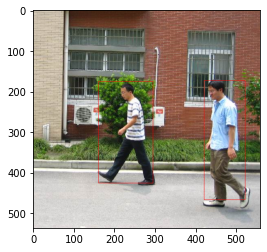

In [18]:
img = Image.open("../datasets/PennFudanPed/PNGImages/FudanPed00001.png").convert("RGB")
img = np.array(img)
show_masks = np.zeros((img.shape[0],img.shape[1]))
show_boxes = []
idx = 0
for data in outputs[0]['scores'].to('cpu').detach().numpy():
    if data < 0.9:
        break
    idx += 1
print("human:{}".format(idx))
for i in range(idx):
    show_masks += outputs[0]['masks'].to('cpu').detach().numpy()[i][0]
    show_boxes.append( [ int(_) for _ in  outputs[0]['boxes'].to('cpu').detach().numpy()[i]] )
print(show_boxes)
for i in show_boxes:
    img = cv2.rectangle(img,(i[0],i[1]),(i[2],i[3]),(255, 0, 0,))
plt.imshow(img)

print(show_masks.shape)
'''
show_masks = Image.fromarray(show_masks,mode='L')
show_masks.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
print(np.array(show_masks).shape)'''

(536, 559, 3)


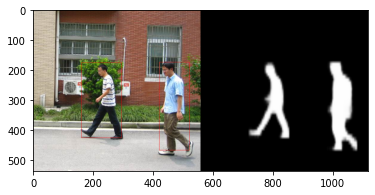

In [35]:
masks = Image.fromarray(show_masks*255).convert("RGB")
masks = np.array(masks)
print(masks.shape)
plt.imshow(np.concatenate((img,masks),axis=1))